ImageGPT
====

**Generative Pretraining from Pixels**

 * Paper: https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf

 ![ImageGPT Overview](../assets/imagegpt_overview.png)


```bash
pip install torch torchvision
pip install -U transformers
# requires huggingface-hub >=0.30.0
```

In [2]:
import huggingface_hub

huggingface_hub.__version__

'0.30.2'

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import (
    ImageGPTImageProcessor,
    ImageGPTForCausalImageModeling
)

processor = ImageGPTImageProcessor.from_pretrained(
   "openai/imagegpt-small"
)
model = ImageGPTForCausalImageModeling.from_pretrained(
   "openai/imagegpt-small"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device);

In [4]:
# unconditional generation of 8 images
batch_size = 8
context = torch.full((batch_size, 1), model.config.vocab_size - 1) #initialize with SOS token
context = torch.tensor(context).to(device)
print("context shape:", context.shape)

output = model.generate(
    inputs=context,
    max_length=model.config.n_positions + 1,
    temperature=1.0, do_sample=True, top_k=40
)
print("output shape:", output.shape)

/tmp/ipykernel_3224/1725894312.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(context).to(device)


context shape: torch.Size([8, 1])


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


output shape: torch.Size([8, 1025])


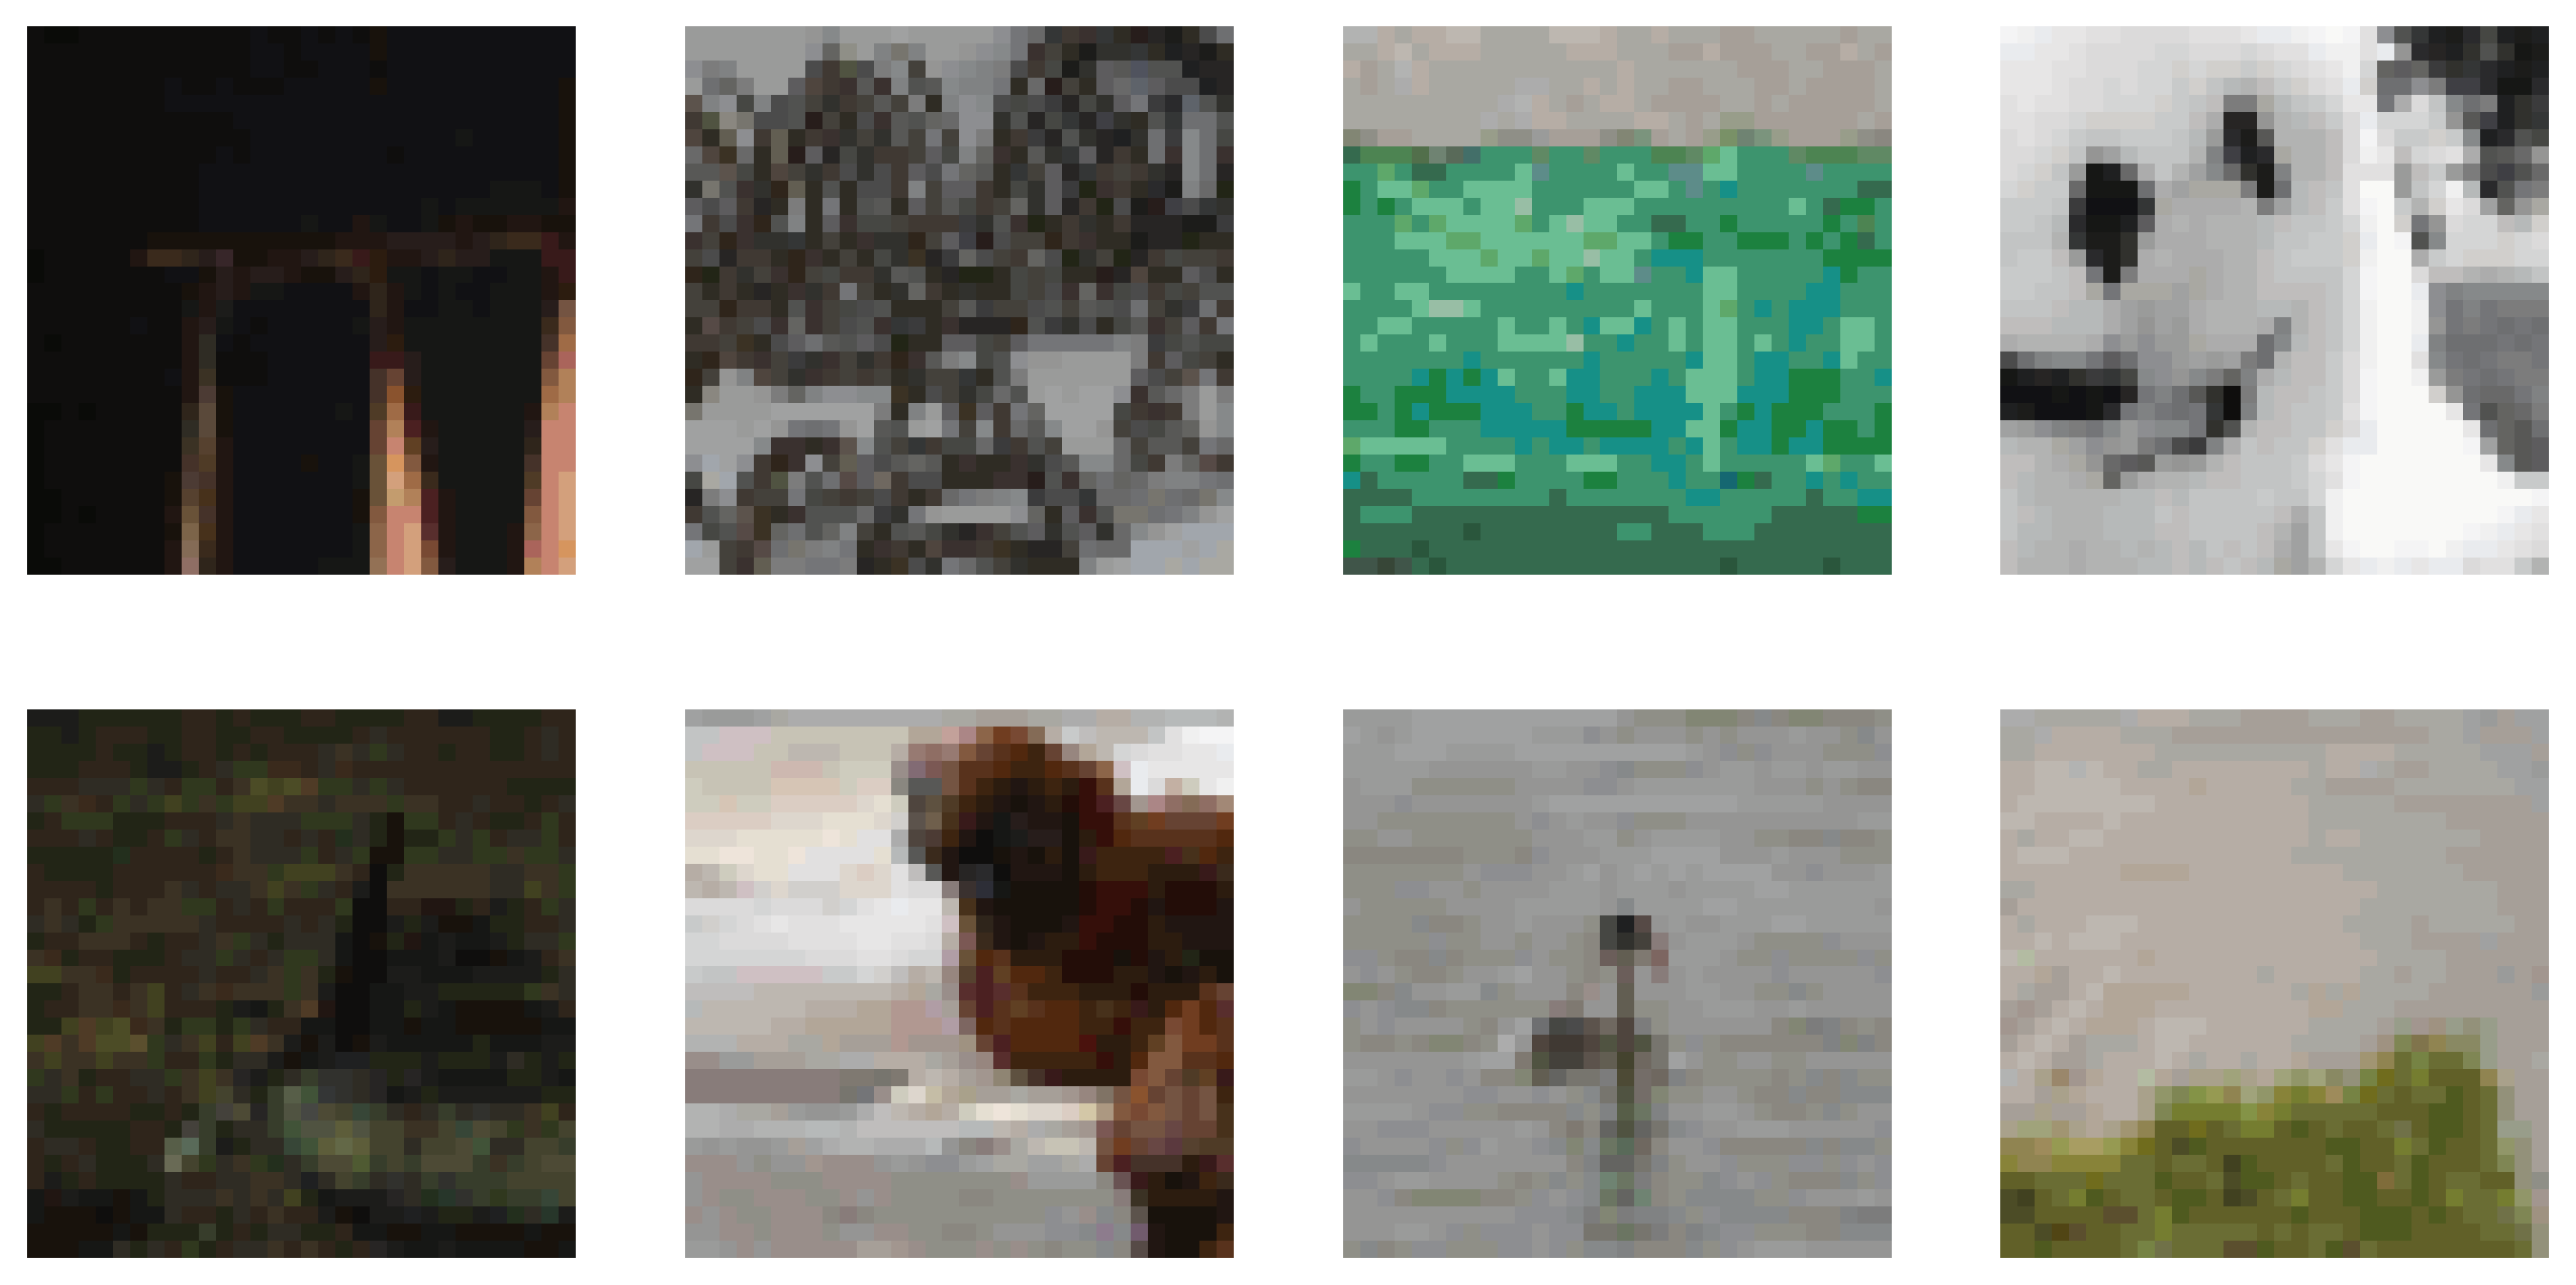

In [8]:
clusters = processor.clusters
n_px = processor.size

samples = output[:,1:].cpu().detach().numpy()

# convert color cluster tokens back to pixels
samples_img = [
   np.reshape(
      np.rint(127.5 * (clusters[s] + 1.0)),
      [n_px["height"], n_px["width"], 3]
   ).astype(np.uint8)
   for s in samples
]

f, axes = plt.subplots(
   2, batch_size // 2,
   figsize=(batch_size // 2 * 3, 6), dpi=300,
)
axes = axes.ravel()
for img, ax in zip(samples_img, axes):
   ax.axis('off')
   ax.imshow(img)